In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

file_path = "../data/data-ml.csv"
df = pd.read_csv(file_path)
df.head()


,id,Country,year,Yearly Score,goal1,goal2,goal3,goal4,goal5,goal6,...,goal8,goal9,goal10,goal11,goal12,goal13,goal14,goal15,goal16,goal17
0,AFG,Afghanistan,2020,"47,47",29.00,38,37,43,26,49,...,47,11,NaN,36,95,99,NaN,78,45,43
1,AFG,Afghanistan,2021,"46,27",20.00,38,35,35,29,50,...,45,11,NaN,34,95,99,NaN,78,45,43
2,AFG,Afghanistan,2019,"46,13",30.00,40,36,43,24,45,...,46,11,NaN,35,95,99,NaN,65,46,41
3,AFG,Afghanistan,2022,"45,60",17.00,38,36,35,18,51,...,43,17,NaN,35,96,99,NaN,77,42,43
4,AFG,Afghanistan,2018,"45,53",30.00,41,37,41,21,42,...,47,11,NaN,33,95,99,NaN,65,46,41


In [2]:
df_country = df[df["Country"] == "Brazil"]
prediction_year = 2021
goal = 'goal1'
df_country[df_country['year'] == prediction_year][goal].values[0]

83.0

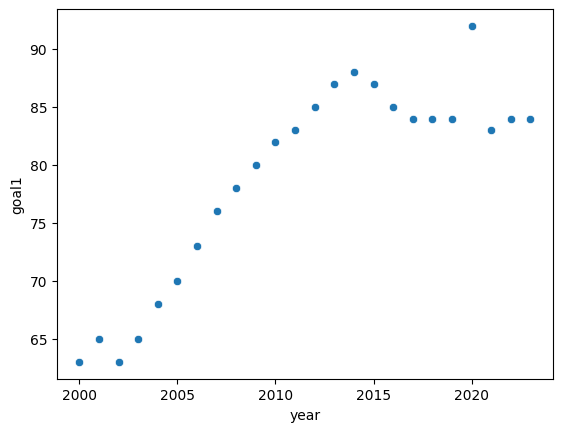

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x="year", y="goal1", data=df[df["Country"] == "Brazil"])
plt.show()

In [7]:
from statsmodels.formula.api import ols
import numpy as np

models_created, models_skipped = 0, 0
no_data = {}
goals = [f"goal{i}" for i in range(1, 18)]
windows = [2020, 2021, 2022]

results = pd.DataFrame(columns=[
    "Country", "Goal", "Window", "Model Type", "Model", "params", "Error (MSE)", "Error (R2)", 
    "Prediction Year", "Prediction", "Actual Value", "Prediction Error"
])

for i, window in enumerate(windows):
    print(f"Window: from {2000+i} to {window} - predicting {window+1} and checking against {window+1}")
    for country in df["Country"].unique():
        for goal in goals:
            df_country = df[df["Country"] == country]
            df_country_year = df_country[(df_country["year"] >= 2000 + i) & (df_country["year"] <= window)]
            if df_country_year[goal].dropna().empty:
                no_data[country] = goal
            else:
                if df_country_year[goal].nunique() > 1:  # Ensure there's variation in the target variable
                    linear_regression = ols(f"{goal} ~ year", data=df_country_year).fit()

                    prediction_year = window + 1
                    prediction = linear_regression.predict({"year": prediction_year})
                    prediction_value = prediction.values[0] if not np.isnan(prediction.values[0]) else None

                    actual_values = df_country[df_country['year'] == prediction_year][goal].values
                    actual_value = actual_values[0] if len(actual_values) > 0 else None
                    prediction_error = prediction_value - actual_value if actual_value is not None and prediction_value is not None else None

                    #print(f"\t{country} - {goal} - Predicting for {prediction_year}\n\t\t"
                    #      f"Prediction: {prediction.values[0]} - Actual Value: {df_country[df_country['year'] == prediction_year][goal].values[0]}\n\t\t"
                    #      f"Error: {prediction.values[0] - df_country[df_country['year'] == prediction_year][goal].values[0]}")
                    new_row = pd.DataFrame([{
                        "Country": country,
                        "Goal": goal,
                        "Window": window,
                        "Model Type": "ols",
                        "Model": linear_regression,
                        "params": linear_regression.params,
                        "Error (MSE)": linear_regression.mse_resid,
                        "Error (R2)": linear_regression.rsquared,
                        "Prediction Year": prediction_year,
                        "Prediction": prediction_value,
                        "Actual Value": actual_value,
                        "Prediction Error": prediction_error,
                        "Squared Prediction Error": ((prediction_error ** 2) ** (1/2) if prediction_error is not None else None)
                    }])
                    models_created += 1
                    if not new_row.dropna(how="all").empty:
                        results = pd.concat([results, new_row.dropna(axis=1, how="all")], ignore_index=True)
                    else:
                        print("Error creating model")
                else:
                    models_skipped += 1
                    #print(f"Skipping {country} - {goal} for window {window}: No variation in data.")
print(f"Models created: {models_created} - Models skipped: {models_skipped}")
results.head(5)

Window: from 2000 to 2020 - predicting 2021 and checking against 2021


/tmp/ipykernel_14442/1790948321.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row.dropna(axis=1, how="all")], ignore_index=True)


Window: from 2001 to 2021 - predicting 2022 and checking against 2022
Window: from 2002 to 2022 - predicting 2023 and checking against 2023
Models created: 8136 - Models skipped: 171


,Country,Goal,Window,Model Type,Model,params,Error (MSE),Error (R2),Prediction Year,Prediction,Actual Value,Prediction Error,Squared Prediction Error
0,Afghanistan,goal1,2020,ols,<statsmodels.regression.linear_model.Regressio...,Intercept -2776.05 year 1.39 dtyp...,16.31,0.83,2021,37.60,20.00,17.60,17.60
1,Afghanistan,goal2,2020,ols,<statsmodels.regression.linear_model.Regressio...,Intercept -1015.56 year 0.52 dtyp...,7.17,0.61,2021,42.19,38.00,4.19,4.19
2,Afghanistan,goal3,2020,ols,<statsmodels.regression.linear_model.Regressio...,Intercept -1971.51 year 0.99 dtyp...,1.52,0.96,2021,38.99,35.00,3.99,3.99
3,Afghanistan,goal4,2020,ols,<statsmodels.regression.linear_model.Regressio...,Intercept -4305.54 year 2.15 dtyp...,118.32,0.61,2021,35.68,35.00,0.68,0.68
4,Afghanistan,goal5,2020,ols,<statsmodels.regression.linear_model.Regressio...,Intercept -484.71 year 0.25 dtype:...,2.39,0.52,2021,21.85,29.00,-7.15,7.15


In [5]:
results.to_csv("../data/results.csv", index=False)

In [6]:
from statsmodels.formula.api import ols
no_data = {}
goals = [f"goal{i}" for i in range(1, 18)]
for country in df["Country"].unique():
    for goal in goals:
        print(f"{country}: {goal}")
        country_df = df[df["Country"] == country]
        if country_df[goal].dropna().empty:
            no_data[country] = goal
        else:
            linear_regression = ols(f"year ~ {goal} + 0", data=df[df["Country"] == country]).fit()
            print(linear_regression.params)

#print(no_data)

Afghanistan: goal1
goal1   79.30
dtype: float64
Afghanistan: goal2
goal2   54.34
dtype: float64
Afghanistan: goal3
goal3   66.31
dtype: float64
Afghanistan: goal4
goal4   57.69
dtype: float64
Afghanistan: goal5
goal5   101.47
dtype: float64
Afghanistan: goal6
goal6   56.01
dtype: float64
Afghanistan: goal7
goal7   69.21
dtype: float64
Afghanistan: goal8
goal8   45.26
dtype: float64
Afghanistan: goal9
goal9   212.72
dtype: float64
Afghanistan: goal10
Afghanistan: goal11
goal11   59.24
dtype: float64
Afghanistan: goal12
goal12   21.13
dtype: float64
Afghanistan: goal13
goal13   20.39
dtype: float64
Afghanistan: goal14
Afghanistan: goal15
goal15   32.34
dtype: float64
Afghanistan: goal16
goal16   45.56
dtype: float64
Afghanistan: goal17
goal17   53.45
dtype: float64
Albania: goal1
goal1   21.15
dtype: float64
Albania: goal2
goal2   40.44
dtype: float64
Albania: goal3
goal3   25.45
dtype: float64
Albania: goal4
goal4   21.82
dtype: float64
Albania: goal5
goal5   42.81
dtype: float64
Albani

KeyboardInterrupt: 

In [21]:
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.formula.api import ols # ordinary least squares
#first argument is formula with explanatory and 
test = ols("year ~ goal9", data=df[df["Country"] == "Brazil"]).fit()
print(test.params)
test.summary()

Intercept   1979.62
goal9          0.59
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   year   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     428.3
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           6.52e-16
Time:                        17:30:06   Log-Likelihood:                -44.263
No. Observations:                  24   AIC:                             92.53
Df Residuals:                      22   BIC:                             94.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1979.6180      1.575   1257.073      0.000    1976.352    1982.884
goal9          0.5863      0.028     20.694      0.000       0.528       0.645
==============================================================================
Omnibus:                        2.770   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.250   Jarque-Bera (JB):                2.355
Skew:                          -0.727   Prob(JB):                        0.308
Kurtosis:                       2.508   Cond. No.                         268.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""